# Next Word Prediction using LSTM

This project demonstrates the implementation of a next word prediction model using Long Short-Term Memory (LSTM) networks. 
The model is trained on a text corpus, tokenized and processed to predict the next word based on a given input sequence of words. 
The project includes data preprocessing, model training, and prediction steps, and showcases the usage of techniques such as tokenization, 
embedding layers, and LSTM layers. The model is capable of generating contextually relevant words in a sequence, providing a foundation 
for applications like autocomplete, text generation, and language modeling.

Key Highlights:
- Data preprocessing including tokenization and padding sequences
- Building and training an LSTM-based neural network model
- Implementing callbacks to save the best model during training
- Predicting the next word in a sequence using the trained model

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
import joblib as jb
import re

2024-08-18 14:00:47.676533: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 14:00:47.676659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 14:00:47.810205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Data
Data Source: https://www.gutenberg.org/cache/epub/1342/pg1342.txt

In [2]:
with open('/kaggle/input/plain-text/Text for prediction.txt', 'r', encoding = 'utf8') as file:
    content = [line for line in file.readlines()]
    
content[:5]

['\ufeffThe Project Gutenberg eBook of Pride and Prejudice\n',
 '    \n',
 'This ebook is for the use of anyone anywhere in the United States and\n',
 'most other parts of the world at no cost and with almost no restrictions\n',
 'whatsoever. You may copy it, give it away or re-use it under the terms\n']

# Preprocess Data

In [3]:
# Remove empty lines
prep_content = [line.strip() for line in content if line.strip()]
prep_content[:5]

['\ufeffThe Project Gutenberg eBook of Pride and Prejudice',
 'This ebook is for the use of anyone anywhere in the United States and',
 'most other parts of the world at no cost and with almost no restrictions',
 'whatsoever. You may copy it, give it away or re-use it under the terms',
 'of the Project Gutenberg License included with this ebook or online']

In [4]:
# Concatenate Text
prep_content = ' '.join(prep_content)
prep_content[:400]

'\ufeffThe Project Gutenberg eBook of Pride and Prejudice This ebook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this ebook or online at www.gutenberg.org. If you are not located in the United States,'

In [5]:
def preprocess(text):
    # Remove URLs (starting with 'www.' or 'http' or 'https')
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # Remove digits, special characters, quotes, double quotes, carriage returns, and newlines
    text_cleaned = re.sub(r'[^\w\s]|\r|\n|\d|["\']', '', text)
    # Replace multiple spaces with a single space
    text_cleaned = re.sub(r'[\s]+', ' ', text_cleaned)
    return text_cleaned

prep_content = preprocess(prep_content)
prep_content[:400]

'The Project Gutenberg eBook of Pride and Prejudice This ebook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever You may copy it give it away or reuse it under the terms of the Project Gutenberg License included with this ebook or online at If you are not located in the United States you will have to check '

In [6]:
# Check length of the data
len(prep_content)

710333

# Tokenize data

In [7]:
# Create tokenizer and fitting data
tokenizer = Tokenizer()
tokenizer.fit_on_texts([prep_content])

# Convert data into sequences
data_sequences = tokenizer.texts_to_sequences([prep_content])[0]
print(data_sequences[:20])

[1, 182, 188, 991, 3, 300, 4, 890, 41, 991, 23, 21, 1, 527, 3, 540, 2609, 8, 1, 674]


In [8]:
# Show length of sequence data
len(data_sequences)

130164

In [9]:
# Show vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

7451


In [10]:
# Create sequences
sequence_length = 3
sequences = []

for i in range(sequence_length, len(data_sequences)):
    words = data_sequences[i - sequence_length: i + 1]
    sequences.append(words)
    
print(f'The length of the sequences is {len(sequences)}')
sequences = np.array(sequences)
print(sequences[:10])

The length of the sequences is 130161
[[  1 182 188 991]
 [182 188 991   3]
 [188 991   3 300]
 [991   3 300   4]
 [  3 300   4 890]
 [300   4 890  41]
 [  4 890  41 991]
 [890  41 991  23]
 [ 41 991  23  21]
 [991  23  21   1]]


# Split data

In [11]:
X, y = [], []
for sequence in sequences:
    X.append(sequence[0:sequence_length])
    y.append(sequence[sequence_length])
    
X = np.array(X)
y = np.array(y)

In [12]:
# Show first five data and its responses
for data, response in zip(X[:5], y[:5]):
    print(f'data: {data}  ->  response: {response}')

data: [  1 182 188]  ->  response: 991
data: [182 188 991]  ->  response: 3
data: [188 991   3]  ->  response: 300
data: [991   3 300]  ->  response: 4
data: [  3 300   4]  ->  response: 890


In [13]:
# Convert responses into categorical responses
y_categorical = to_categorical(y, num_classes = vocab_size)
y_categorical[0]

array([0., 0., 0., ..., 0., 0., 0.])

# Modeling

In [14]:
# Define model
model = Sequential([
    InputLayer(input_shape=(sequence_length,)),
    Embedding(vocab_size, 100),
    LSTM(1000, return_sequences=True),
    LSTM(1000),
    Dense(1000, activation='relu'),
    Dense(vocab_size, activation='softmax')
])

# View the model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 3, 100)         │       745,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3, 1000)        │     4,404,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1000)           │     8,004,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7451)           │     7,458,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,612,551 (82.45 MB)

 Trainable params: 21,612,551 (82.45 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer='adam', loss=CategoricalCrossentropy())
# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint('model.keras', monitor='loss', verbose=1, save_best_only=True)

In [16]:
# Train the model with the checkpoint callback
history = model.fit(X, y_categorical, 
                    epochs=50,
                    batch_size = 64,
                    callbacks=[checkpoint]
                   )

Epoch 1/50
2032/2034 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.4770
Epoch 1: loss improved from inf to 6.12582, saving model to model.keras
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - loss: 6.4765
Epoch 2/50
2032/2034 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.4840
Epoch 2: loss improved from 6.12582 to 5.44952, saving model to model.keras
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - loss: 5.4839
Epoch 3/50
2032/2034 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.1231
Epoch 3: loss improved from 5.44952 to 5.09109, saving model to model.keras
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - loss: 5.1230
Epoch 4/50
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.8063
Epoch 4: loss improved from 5.09109 to 4.81716, saving model to model.keras
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - loss: 4.8063
Epoch 5/50
2031/2034 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.5670
Epoch 5: loss improved from 4.81716 to 4.57722, saving model to model.keras
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 31s

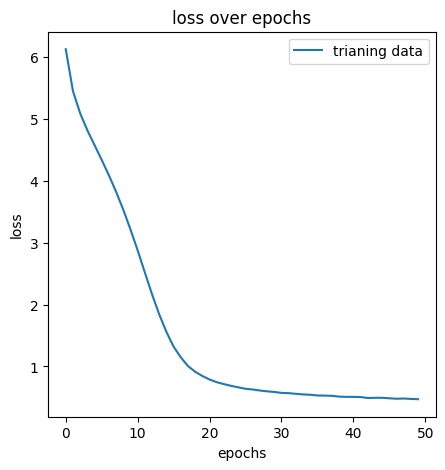

In [17]:
# Visualize the accuracy with the loss
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'])
plt.title("loss over epochs")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["trianing data"],loc="upper right")

# Create predictive system

In [18]:
# Handle text content before feed it into model 
def handle_input(text):
    strip_text = text.strip()
    cleaned_text = preprocess(strip_text)
    return cleaned_text

# Predictive system to predict one word each time based on last three words
def predict_next_word(text):
    handled_text = text.split(' ')[-3:]
    sequence = tokenizer.texts_to_sequences([handled_text])
    sequence = pad_sequences(sequence, maxlen = sequence_length, padding = 'pre')
    sequence = np.array(sequence)
    preds = np.argmax(model.predict(sequence))
    
    predicted_word = ''
    for key, value in tokenizer.word_index.items():
        if value == preds:
            predicted_word = key
            break
    return predicted_word
    
    
    
text = 'The'
number_of_desired_words = 50
handled_text = handle_input(text)

for _ in range(number_of_desired_words):
    predicted_word = predict_next_word(handled_text)
    handled_text = handled_text + ' ' + predicted_word
print(handled_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

In [19]:
# Save the tokenizer
jb.dump(tokenizer, 'PrepareModel\\tokenizer.sav')

['tokenizer.sav']

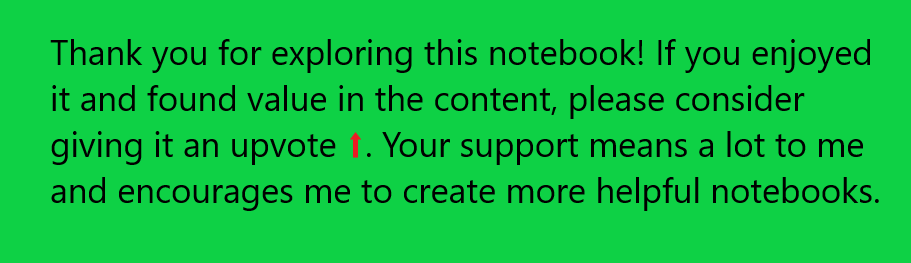